# Model Evaluation

In [1]:
from __future__ import print_function

import copy
import os.path as osp

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
import random
import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)

from model import (
    MyDataset,
    EarlyStopping,
    Resnet18Dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
MODEL = 'Resnet'
CLASSES = 4
DROPOUT = None


In [3]:
def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))


def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))


def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)

In [4]:
def demo1(images, classes, model, target_layer, arch, topk, output_dir, device):
    """
    Visualize model responses given multiple images
    """

    # Model
    model = model
    model.to(device)
    model.eval()

    """
    Common usage:
    1. Wrap your model with visualization classes defined in grad_cam.py
    2. Run forward() with images
    3. Run backward() with a list of specific classes
    4. Run generate() to export results
    """

    # =========================================================================
    print("Vanilla Backpropagation:")

    bp = BackPropagation(model=model)
    probs, ids = bp.forward(images)  # sorted

    for i in range(topk):
        bp.backward(ids=ids[:, [i]])
        gradients = bp.generate()

        # Save results as image files
        # for j in range(len(images)):
        #     print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

        #     save_gradient(
        #         filename=osp.join(
        #             output_dir,
        #             "{}-Class{}-{}-{}-vanilla-{}.png".format(MODEL, CLASSES, j, arch, classes[ids[j, i]]),
        #         ),
        #         gradient=gradients[j],
        #     )

    # Remove all the hook function in the "model"
    bp.remove_hook()

    # =========================================================================
    print("Deconvolution:")

    deconv = Deconvnet(model=model)
    _ = deconv.forward(images)

    for i in range(topk):
        deconv.backward(ids=ids[:, [i]])
        gradients = deconv.generate()

        # for j in range(len(images)):
        #     print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

        #     save_gradient(
        #         filename=osp.join(
        #             output_dir,
        #             "{}-Class{}-{}-{}-deconvnet-{}.png".format(MODEL, CLASSES, j, arch, classes[ids[j, i]]),
        #         ),
        #         gradient=gradients[j],
        #     )

    deconv.remove_hook()

    # =========================================================================
    print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")

    gcam = GradCAM(model=model)
    _ = gcam.forward(images)

    gbp = GuidedBackPropagation(model=model)
    _ = gbp.forward(images)

    for i in range(topk):
        # Guided Backpropagation
        gbp.backward(ids=ids[:, [i]])
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids[:, [i]])
        regions = gcam.generate(target_layer=target_layer)

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))
            

            # Guided Backpropagation
            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-Class{}-{}-{}-guided-{}.png".format(MODEL, CLASSES, j, arch, classes[ids[j, i]]),
                ),
                gradient=gradients[j],
            )

            # Grad-CAM
            save_gradcam(
                filename=osp.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )

            # Guided Grad-CAM
            save_gradient(
                filename=osp.join(
                    output_dir,
                    "{}-Class{}-{}-{}-guided_gradcam-{}-{}.png".format(
                        MODEL, CLASSES, j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gradient=torch.mul(regions, gradients)[j],
            )

In [5]:
def demo3(images, classes, model, arch, topk, stride, n_batches, output_dir, device):
    """
    Generate occlusion sensitivity maps
    """

    # Model
    model = model
    model.to(device)
    model.eval()

    print("Occlusion Sensitivity:")

    patche_sizes = [15]

    logits = model(images)
    probs = F.softmax(logits, dim=1)
    probs, ids = probs.sort(dim=1, descending=True)

    for i in range(topk):
        for p in patche_sizes:
            print("Patch:", p)
            sensitivity = occlusion_sensitivity(
                model, images, ids[:, [i]], patch=p, stride=stride, n_batches=n_batches
            )

            # Save results as image files
            for j in range(len(images)):
                print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

                save_sensitivity(
                    filename=osp.join(
                        output_dir,
                        "{}-Class{}-{}-{}-sensitivity-{}-{}.png".format(
                            MODEL, CLASSES, j, arch, p, classes[ids[j, i]]
                        ),
                    ),
                    maps=sensitivity[j],
                )

# Run

In [6]:
if 'Resnet' in MODEL:
    IMAGE_SIZE = 224
else:
    IMAGE_SIZE = 227

if CLASSES == 2:
    categories = ["COVID-19", "non-COVID-19"]
else:
    categories = ["COVID-19", "Viral", "Bacterial", "Normal"]

In [7]:
try:
    file_model = open('./Results/model'+str(MODEL)+'Dropout'+str(DROPOUT)+'Class'+str(CLASSES)+'.pkl', "rb")
except IOError:
    print("File not accessible")
  
all_results = pickle.load(file_model)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

def evaluate_model(model, dataloaders, criterion):
    # best model
    running_loss = 0.0
    running_corrects = 0

    true_labels = []
    probabilities = []
    predictions = []

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            probabilities.extend(list(probs.cpu().numpy()))
            predictions.extend(list(preds.cpu().numpy()))
            true_labels.extend(list(labels.cpu().numpy()))

            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    probabilities = np.array(probabilities)
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

    print(confusion_matrix(true_labels, predictions))
    print(classification_report(true_labels, predictions))

    return true_labels, probabilities, predictions, confusion_matrix


In [9]:
try:
    file = open('./Dataset/data'+str(IMAGE_SIZE)+'Class'+str(CLASSES)+'.pkl', "rb")
except IOError:
    print("File not accessible")

data = pickle.load(file)
if CLASSES == 2:
    categories = ["COVID-19", "non-COVID-19"]
else:
    categories = ["COVID-19", "Viral", "Bacterial", "Normal"]

train_images, train_labels = data['train image'], data['train label']
test_image, test_label = data['test image'], data['test label']

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(15, translate=(0.1,0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def data_process(train_image, train_label, test_image, test_label, current_phase = 'valid'):
# Data augmentation and normalization for training
# Just normalization for validation

    trainset = MyDataset(train_image, train_label, data_transforms['train'])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

    testset = MyDataset(test_image, test_label, data_transforms[current_phase])
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

    dataloaders = {'train': trainloader, current_phase: testloader}

    dataset_sizes = {'train': len(trainset), current_phase: len(testset)}

    return dataloaders, dataset_sizes
dataloaders, dataset_sizes = data_process(train_images, train_labels, test_image, test_label, current_phase='test')


In [11]:
true_labels, probabilities, predictions, confusion_matrix = evaluate_model(all_results['model'], dataloaders, criterion = nn.CrossEntropyLoss())

test Loss: 0.2742 Acc: 0.9240
[[ 60   0   0   0]
 [  0 121  24   3]
 [  0   5 235   2]
 [  2   9   7 216]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.90      0.82      0.86       148
           2       0.88      0.97      0.93       242
           3       0.98      0.92      0.95       234

   micro avg       0.92      0.92      0.92       684
   macro avg       0.93      0.93      0.93       684
weighted avg       0.93      0.92      0.92       684



In [12]:
import seaborn as sns

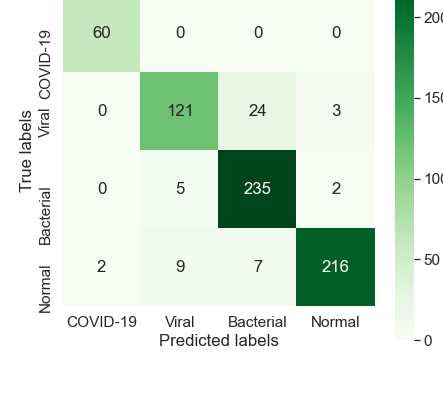

In [13]:
if CLASSES == 4:
    plt.figure(figsize=(7,7))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(confusion_matrix(true_labels, predictions), cmap = 'Greens', annot= True,\
                fmt = 'g', square = True, xticklabels=['COVID-19', 'Viral', 'Bacterial', 'Normal'],\
                yticklabels=['COVID-19', 'Viral', 'Bacterial', 'Normal'])
    ax.set(xlabel = 'Predicted labels', ylabel = 'True labels')
else:
    plt.figure(figsize=(7,7))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(confusion_matrix1, cmap = 'Greens', annot= True, annot_kws={"size": 20},\
                fmt = 'g', square = True, xticklabels=['COVID-19', 'Non-COVID-19'],\
                yticklabels=['COVID-19', 'Non-COVID-19'], cbar = True)
    ax.set(xlabel = 'Predicted labels', ylabel = 'True labels')

In [14]:
model = all_results['model']
for params in model.parameters():
    params.requires_grad = True

In [15]:
raw_images = []
images = []
labels = []

In [16]:
# path to covid-19 dataset from https://github.com/ieee8023/covid-chestxray-dataset
covid_image_path = './Dataset/covid-chestxray-dataset-master/images/' 
covid_csv_path = './Dataset/covid-chestxray-dataset-master/metadata.csv'

# path to CellData
xray_image_path = './Dataset/CellData/chest_xray/'

# select COVID-19 x-rays from ieee dataset
covid_csv = pd.read_csv(covid_csv_path, nrows=None)
image_idx = (covid_csv["finding"].str.contains("COVID-19")) & (covid_csv["modality"] == "X-ray") & (covid_csv["view"] != "L")
covid_csv = covid_csv[image_idx]

# read COVID-19 images
covid_image = []
for filename in covid_csv['filename']:
    imagefile=cv2.imread(covid_image_path + filename)
    imagefile = cv2.resize(imagefile, (IMAGE_SIZE,IMAGE_SIZE)) 
    covid_image.append(imagefile)

In [17]:
covid_image_path = './Dataset/COVID-figures/' 
files = os.listdir(covid_image_path)
files.sort()

for i in tqdm(range(len(files))):
    filesname = covid_image_path + '/' + files[i]
    if filesname == covid_image_path + '/.DS_Store':
        continue
    imagefile=cv2.imread(filesname)
    imagefile = cv2.resize(imagefile, (IMAGE_SIZE,IMAGE_SIZE))
    raw_images.append(imagefile)


100%|██████████| 19/19 [00:00<00:00, 107.01it/s]


In [18]:
for raw_image in raw_images:
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])(raw_image[..., ::-1].copy())
    images.append(image)
images = torch.stack(images).to(device)

In [19]:
classes = [0]*19

In [20]:
output_dir = './Results/Figures'

In [21]:
demo1(images, classes, model, 'layer4', arch=str(MODEL)+'Dropout'+str(DROPOUT)+'Class'+str(CLASSES)\
    , topk=1, output_dir=output_dir, device=device)

Vanilla Backpropagation:
Deconvolution:
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
	#0: 0 (0.96925)
	#1: 0 (0.96870)
	#2: 0 (0.94866)
	#3: 0 (0.92420)
	#4: 0 (0.96583)
	#5: 0 (0.97642)
	#6: 0 (0.97675)
	#7: 0 (0.97299)
	#8: 0 (0.96035)
	#9: 0 (0.96719)
	#10: 0 (0.96837)
	#11: 0 (0.95423)
	#12: 0 (0.96328)
	#13: 0 (0.91436)
	#14: 0 (0.95198)
	#15: 0 (0.95437)
	#16: 0 (0.93540)
	#17: 0 (0.97562)
	#18: 0 (0.97244)


In [22]:
# demo3(images[:10], labels, model, stride = 2, n_batches = 64, arch=str(MODEL)+'Dropout'+str(DROPOUT)+'Class'+str(CLASSES),\
#      topk=1, output_dir=output_dir, device=device)